In [65]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, KFold
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error

import tensorflow as tf
from tensorflow.keras import layers
from keras.layers import Dense
from keras import regularizers
from keras.models import Sequential

In [2]:
dane = pd.read_csv(r'C:\Users\olga.zieba\Desktop\Sacramento_real_estate_transactions.csv', sep=',')
dane

,street,city,zip,state,beds,baths,sq__ft,type,sale_date,price,latitude,longitude
0,3526 HIGH ST,SACRAMENTO,95838,CA,2,1,836,Residential,Wed May 21 00:00:00 EDT 2008,59222,38.631913,-121.434879
1,51 OMAHA CT,SACRAMENTO,95823,CA,3,1,1167,Residential,Wed May 21 00:00:00 EDT 2008,68212,38.478902,-121.431028
2,2796 BRANCH ST,SACRAMENTO,95815,CA,2,1,796,Residential,Wed May 21 00:00:00 EDT 2008,68880,38.618305,-121.443839
3,2805 JANETTE WAY,SACRAMENTO,95815,CA,2,1,852,Residential,Wed May 21 00:00:00 EDT 2008,69307,38.616835,-121.439146
4,6001 MCMAHON DR,SACRAMENTO,95824,CA,2,1,797,Residential,Wed May 21 00:00:00 EDT 2008,81900,38.519470,-121.435768
...,...,...,...,...,...,...,...,...,...,...,...,...
980,9169 GARLINGTON CT,SACRAMENTO,95829,CA,4,3,2280,Residential,Thu May 15 00:00:00 EDT 2008,232425,38.457679,-121.359620
981,6932 RUSKUT WAY,SACRAMENTO,95823,CA,3,2,1477,Residential,Thu May 15 00:00:00 EDT 2008,234000,38.499893,-121.458890
982,7933 DAFFODIL WAY,CITRUS HEIGHTS,95610,CA,3,2,1216,Residential,Thu May 15 00:00:00 EDT 2008,235000,38.708824,-121.256803
983,8304 RED FOX WAY,ELK GROVE,95758,CA,4,2,1685,Residential,Thu May 15 00:00:00 EDT 2008,235301,38.417000,-121.397424


sq__ft - powierzchnia mieszkania

In [3]:
df = dane.copy()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 985 entries, 0 to 984
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   street     985 non-null    object 
 1   city       985 non-null    object 
 2   zip        985 non-null    int64  
 3   state      985 non-null    object 
 4   beds       985 non-null    int64  
 5   baths      985 non-null    int64  
 6   sq__ft     985 non-null    int64  
 7   type       985 non-null    object 
 8   sale_date  985 non-null    object 
 9   price      985 non-null    int64  
 10  latitude   985 non-null    float64
 11  longitude  985 non-null    float64
dtypes: float64(2), int64(5), object(5)
memory usage: 92.5+ KB


In [5]:
for i in df.columns:
    print(df[i].value_counts(), end='\n\n')

8306 CURLEW CT         2
4734 14TH AVE          2
1223 LAMBERTON CIR     2
7 CRYSTALWOOD CIR      2
3526 HIGH ST           1
                      ..
2981 WRINGER DR        1
8616 ROCKPORTE CT      1
4128 HILL ST           1
1409 47TH ST           1
3882 YELLOWSTONE LN    1
Name: street, Length: 981, dtype: int64

SACRAMENTO         439
ELK GROVE          114
LINCOLN             72
ROSEVILLE           48
CITRUS HEIGHTS      35
ANTELOPE            33
RANCHO CORDOVA      28
EL DORADO HILLS     23
GALT                21
NORTH HIGHLANDS     21
CARMICHAEL          20
FOLSOM              17
ROCKLIN             17
RIO LINDA           13
ORANGEVALE          11
PLACERVILLE         10
CAMERON PARK         9
FAIR OAKS            9
WILTON               5
AUBURN               5
GOLD RIVER           4
ELVERTA              4
WEST SACRAMENTO      3
RANCHO MURIETA       3
POLLOCK PINES        3
GRANITE BAY          3
LOOMIS               2
EL DORADO            2
MATHER               1
PENRYN           

In [6]:
# Dane kategoryczne
print(df.describe(exclude=[np.number]).shape)
df.describe(exclude=[np.number])

(4, 5)


,street,city,state,type,sale_date
count,985,985,985,985,985
unique,981,39,1,4,5
top,8306 CURLEW CT,SACRAMENTO,CA,Residential,Mon May 19 00:00:00 EDT 2008
freq,2,439,985,917,268


In [7]:
#Niska wariancja dla danych jakościowych - usuwamy zmienną state i type (model działa lepej bez tych zmiennych)
cat_cols = df.select_dtypes(include=['object'])
print(cat_cols.shape)
high_frq_col = []
for col in cat_cols:
    counts = df[col].value_counts()
    for count in counts:
        if count > 900 :
            high_frq_col.append(col)
print(high_frq_col)
cat_cols.drop(axis=1,columns=high_frq_col,inplace = True)
df.drop(axis=1,columns=high_frq_col,inplace = True)
cat_cols.isna().sum()[cat_cols.isna().sum() != 0]

(985, 5)
['state', 'type']


Series([], dtype: int64)

freq w poprzedniej tabeli jest wartość liczy dla najczęstszej wartości (top) w tych danych katagorycznych więc jeśli tak duże (więcej niż 1000) według danych rekordów numer to jest wskazanie, że mają bardzo niską wariancję więc możemy porzucić te deaturer

In [8]:
df.duplicated().value_counts() 

False    982
True       3
dtype: int64

In [9]:
duplicate = df[df.duplicated()]
print("Duplikaty :")
duplicate

Duplikaty :


,street,city,zip,beds,baths,sq__ft,sale_date,price,latitude,longitude
342,4734 14TH AVE,SACRAMENTO,95820,2,1,834,Mon May 19 00:00:00 EDT 2008,68000,38.539447,-121.450858
404,8306 CURLEW CT,CITRUS HEIGHTS,95621,4,2,1280,Mon May 19 00:00:00 EDT 2008,167293,38.715781,-121.298519
601,7 CRYSTALWOOD CIR,LINCOLN,95648,0,0,0,Mon May 19 00:00:00 EDT 2008,4897,38.885962,-121.289436


In [10]:
df.isnull().sum()

street       0
city         0
zip          0
beds         0
baths        0
sq__ft       0
sale_date    0
price        0
latitude     0
longitude    0
dtype: int64

In [11]:
df

,street,city,zip,beds,baths,sq__ft,sale_date,price,latitude,longitude
0,3526 HIGH ST,SACRAMENTO,95838,2,1,836,Wed May 21 00:00:00 EDT 2008,59222,38.631913,-121.434879
1,51 OMAHA CT,SACRAMENTO,95823,3,1,1167,Wed May 21 00:00:00 EDT 2008,68212,38.478902,-121.431028
2,2796 BRANCH ST,SACRAMENTO,95815,2,1,796,Wed May 21 00:00:00 EDT 2008,68880,38.618305,-121.443839
3,2805 JANETTE WAY,SACRAMENTO,95815,2,1,852,Wed May 21 00:00:00 EDT 2008,69307,38.616835,-121.439146
4,6001 MCMAHON DR,SACRAMENTO,95824,2,1,797,Wed May 21 00:00:00 EDT 2008,81900,38.519470,-121.435768
...,...,...,...,...,...,...,...,...,...,...
980,9169 GARLINGTON CT,SACRAMENTO,95829,4,3,2280,Thu May 15 00:00:00 EDT 2008,232425,38.457679,-121.359620
981,6932 RUSKUT WAY,SACRAMENTO,95823,3,2,1477,Thu May 15 00:00:00 EDT 2008,234000,38.499893,-121.458890
982,7933 DAFFODIL WAY,CITRUS HEIGHTS,95610,3,2,1216,Thu May 15 00:00:00 EDT 2008,235000,38.708824,-121.256803
983,8304 RED FOX WAY,ELK GROVE,95758,4,2,1685,Thu May 15 00:00:00 EDT 2008,235301,38.417000,-121.397424


In [12]:
from sklearn.preprocessing import LabelEncoder

categ = ['city', 'sale_date']
le = LabelEncoder()
df[categ] = df[categ].apply(le.fit_transform)

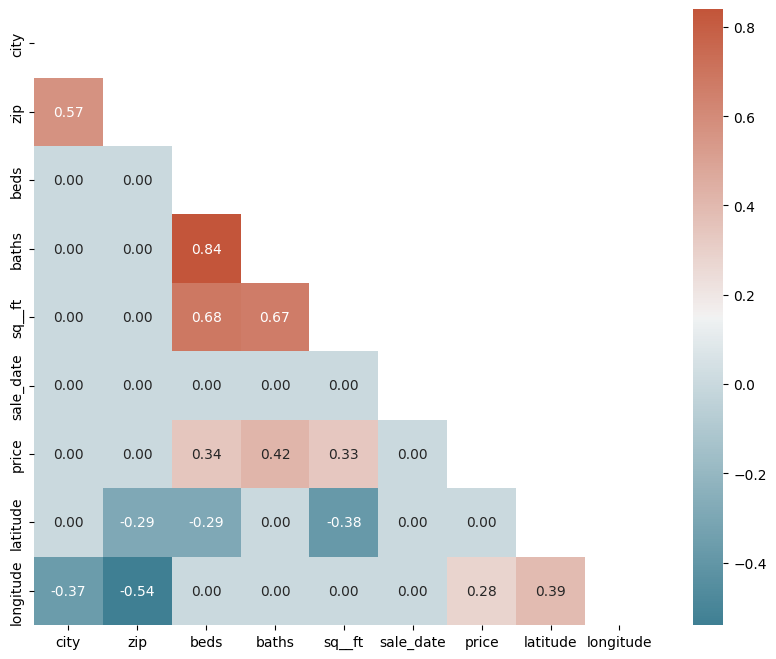

In [13]:
plt.figure(figsize=(10,8))  

corr = df.corr()
cmap = sns.diverging_palette(220, 20, as_cmap=True)
plt.rcParams['figure.figsize'] = (8, 8)
mask = np.triu(corr)
corr[(corr.values < 0.25) & (corr.values > -0.25)] = 0

sns.heatmap(corr, annot = True, fmt = '.2f', mask = mask, cmap=cmap);

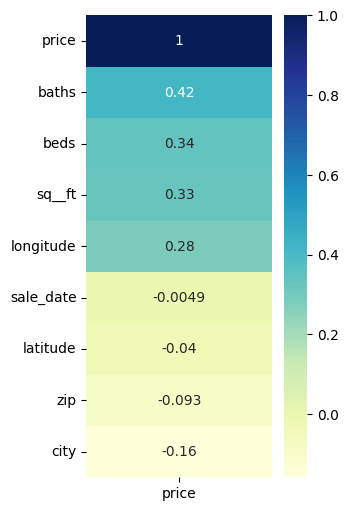

In [14]:
fig, ax = plt.subplots(figsize=(3,6))
sns.heatmap(df.corr(method='pearson')[['price']].sort_values('price').tail(10),
cmap='YlGnBu', annot=True, ax=ax)
ax.invert_yaxis()

In [15]:
df.drop([ 'street'], axis = 1, inplace=True)

### Wizualizacja

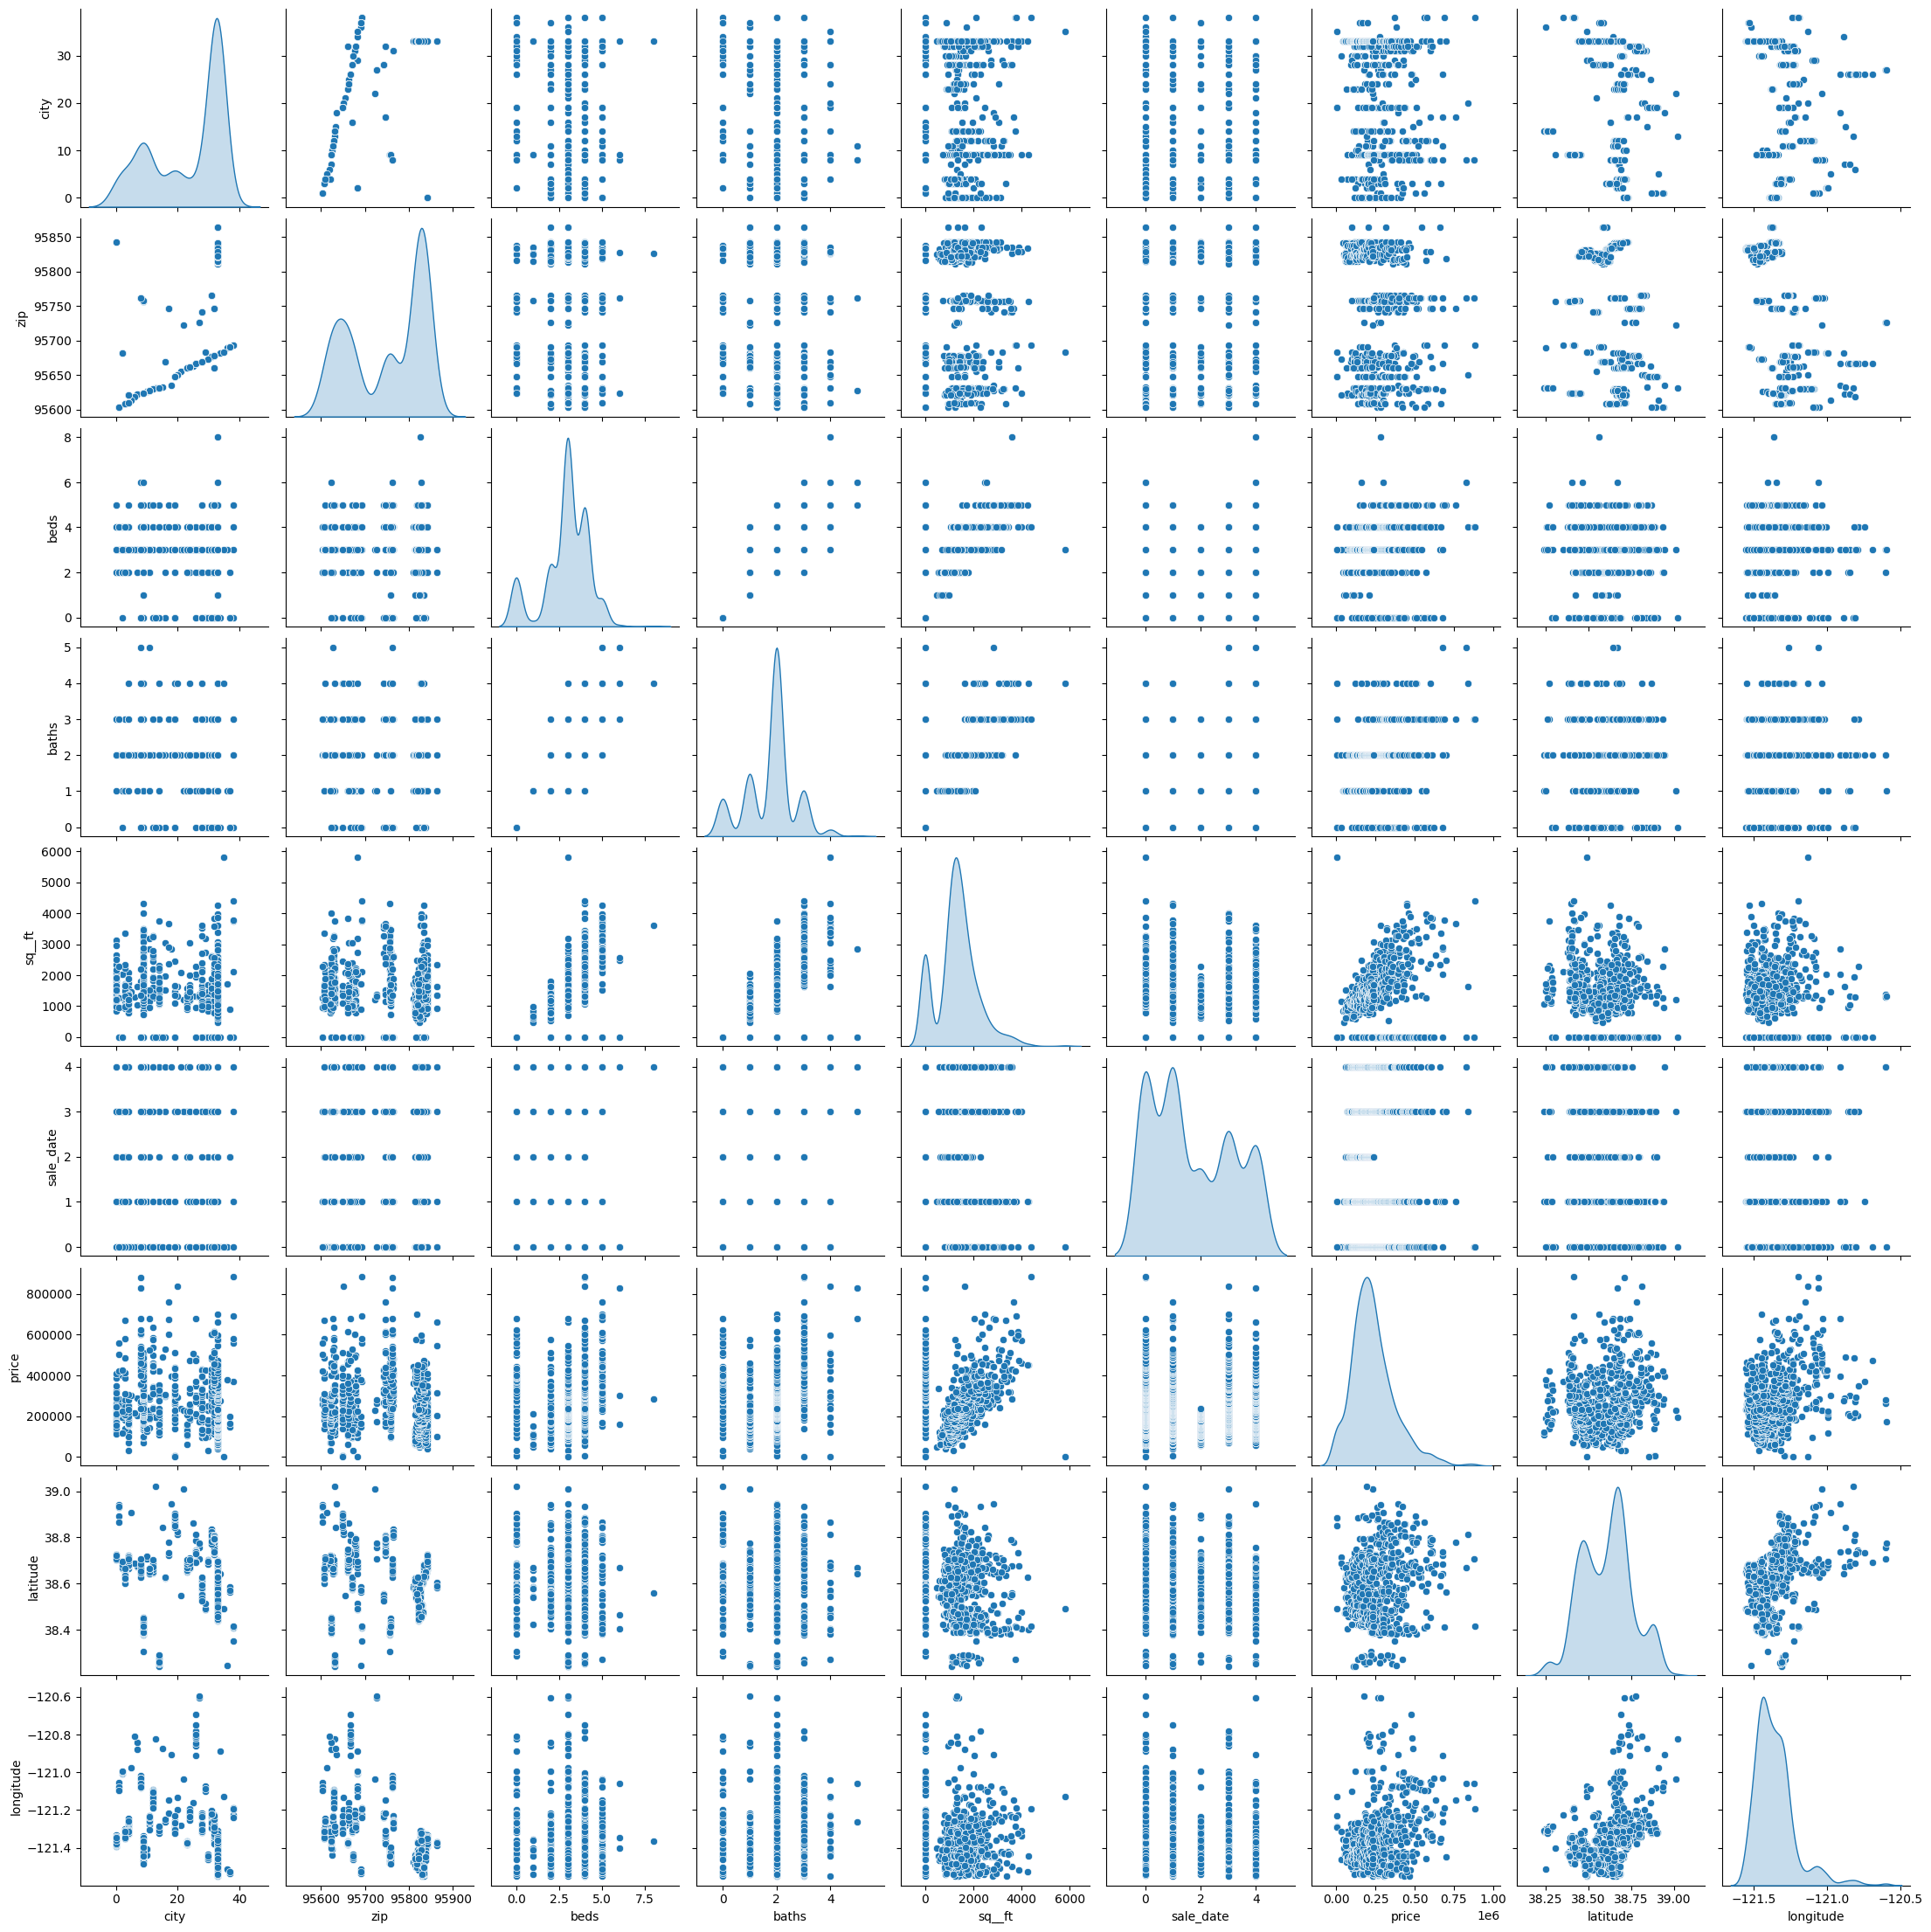

In [16]:
sns.pairplot(df, diag_kind="kde")

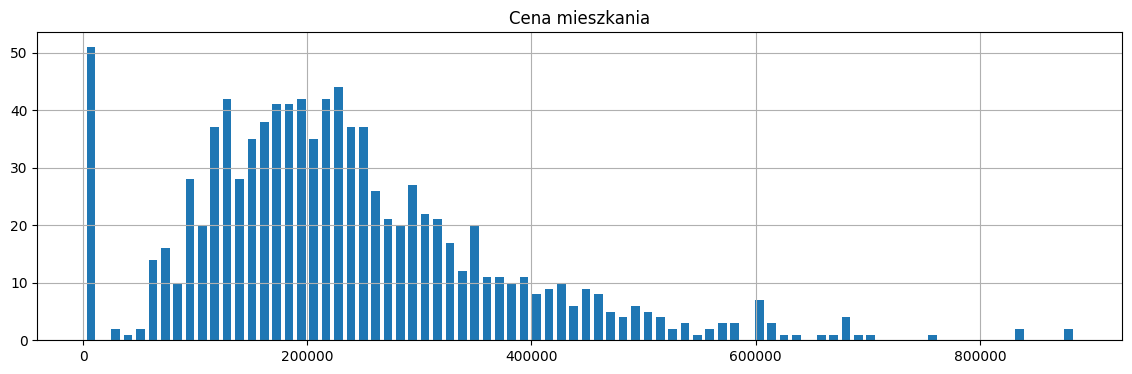

In [17]:
df.price.hist(bins=80,rwidth=0.7,figsize=(14,4))
plt.title('Cena mieszkania')
plt.show()

In [18]:
df['price'].value_counts()

4897      49
220000    10
170000     9
150000     9
250000     9
          ..
495000     1
485000     1
484000     1
480000     1
235738     1
Name: price, Length: 605, dtype: int64

In [19]:
dane.loc[(dane['price']==4897)] 

,street,city,zip,state,beds,baths,sq__ft,type,sale_date,price,latitude,longitude
554,20 CRYSTALWOOD CIR,LINCOLN,95648,CA,0,0,0,Residential,Mon May 19 00:00:00 EDT 2008,4897,38.885327,-121.289412
555,24 CRYSTALWOOD CIR,LINCOLN,95648,CA,0,0,0,Residential,Mon May 19 00:00:00 EDT 2008,4897,38.885132,-121.289405
556,28 CRYSTALWOOD CIR,LINCOLN,95648,CA,0,0,0,Residential,Mon May 19 00:00:00 EDT 2008,4897,38.884936,-121.289397
557,32 CRYSTALWOOD CIR,LINCOLN,95648,CA,0,0,0,Residential,Mon May 19 00:00:00 EDT 2008,4897,38.884741,-121.289390
558,36 CRYSTALWOOD CIR,LINCOLN,95648,CA,0,0,0,Residential,Mon May 19 00:00:00 EDT 2008,4897,38.884599,-121.289406
559,40 CRYSTALWOOD CIR,LINCOLN,95648,CA,0,0,0,Residential,Mon May 19 00:00:00 EDT 2008,4897,38.884535,-121.289619
560,44 CRYSTALWOOD CIR,LINCOLN,95648,CA,0,0,0,Residential,Mon May 19 00:00:00 EDT 2008,4897,38.884590,-121.289835
561,48 CRYSTALWOOD CIR,LINCOLN,95648,CA,0,0,0,Residential,Mon May 19 00:00:00 EDT 2008,4897,38.884667,-121.289896
562,52 CRYSTALWOOD CIR,LINCOLN,95648,CA,0,0,0,Residential,Mon May 19 00:00:00 EDT 2008,4897,38.884780,-121.289911
563,68 CRYSTALWOOD CIR,LINCOLN,95648,CA,0,0,0,Residential,Mon May 19 00:00:00 EDT 2008,4897,38.885236,-121.289928


In [20]:
dane.groupby(['baths'])['price'].agg([min, max, 'mean', 'count'])

,min,max,mean,count
baths,,,,
0,4897,680000,187585.046296,108
1,40000,575000,159024.666667,180
2,4897,699000,226498.976103,544
3,1551,884790,380352.143939,132
4,2000,839000,358765.736842,19
5,680000,830000,755000.000000,2


In [21]:
dane.groupby(['type'])['price'].agg([min, max, 'mean', 'count'])

,min,max,mean,count
type,,,,
Condo,40000,360000,150082.185185,54
Multi-Family,100000,416767,224534.692308,13
Residential,1551,884790,239186.162486,917
Unkown,275000,275000,275000.000000,1


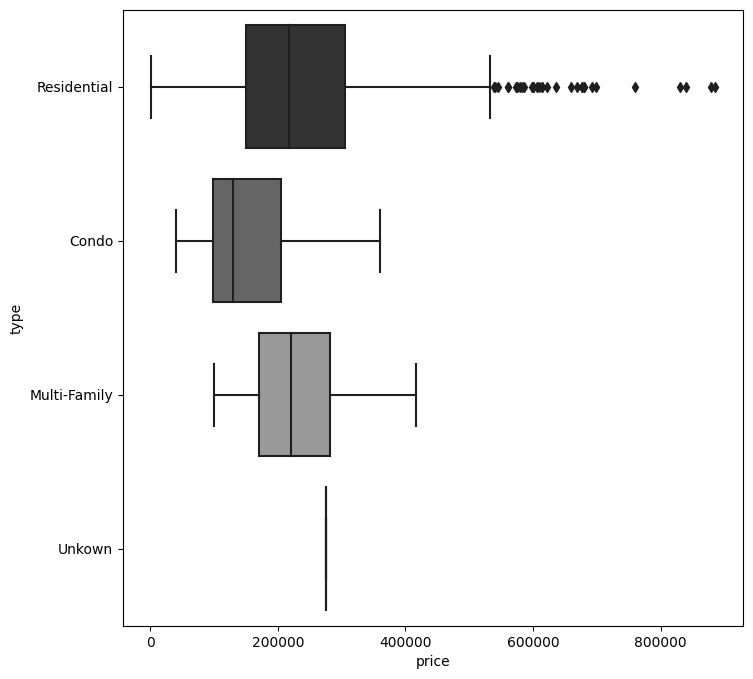

In [22]:
sns.boxplot(y="type", x="price", data=dane, palette = 'gray');


In [23]:
dane.describe()

,zip,beds,baths,sq__ft,price,latitude,longitude
count,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000
mean,95750.697462,2.911675,1.776650,1314.916751,234144.263959,38.607732,-121.355982
std,85.176072,1.307932,0.895371,853.048243,138365.839085,0.145433,0.138278
min,95603.000000,0.000000,0.000000,0.000000,1551.000000,38.241514,-121.551704
25%,95660.000000,2.000000,1.000000,952.000000,145000.000000,38.482717,-121.446127
50%,95762.000000,3.000000,2.000000,1304.000000,213750.000000,38.626582,-121.376220
75%,95828.000000,4.000000,2.000000,1718.000000,300000.000000,38.695589,-121.295778
max,95864.000000,8.000000,5.000000,5822.000000,884790.000000,39.020808,-120.597599


In [24]:
ranges=[1551,294546,589092,884791]
df['price_cut']=pd.cut(df['price'], bins=ranges)

In [25]:
df['price_cut'].value_counts()

(1551, 294546]      722
(294546, 589092]    237
(589092, 884791]     25
Name: price_cut, dtype: int64

In [26]:
df.groupby(['price_cut'])['beds'].agg([min, max, 'mean', 'count'])

,min,max,mean,count
price_cut,,,,
"(1551, 294546]",0,8,2.771468,722
"(294546, 589092]",0,6,3.240506,237
"(589092, 884791]",0,6,3.840000,25


In [27]:
df.groupby(['price_cut'])['sq__ft'].agg([min, max, 'mean', 'count'])

,min,max,mean,count
price_cut,,,,
"(1551, 294546]",0,5822,1204.790859,722
"(294546, 589092]",0,4303,1601.784810,237
"(589092, 884791]",0,4400,1828.440000,25


In [28]:
col_list = dane[['baths', 'beds', 'sq__ft']].columns.tolist()
col_list

['baths', 'beds', 'sq__ft']

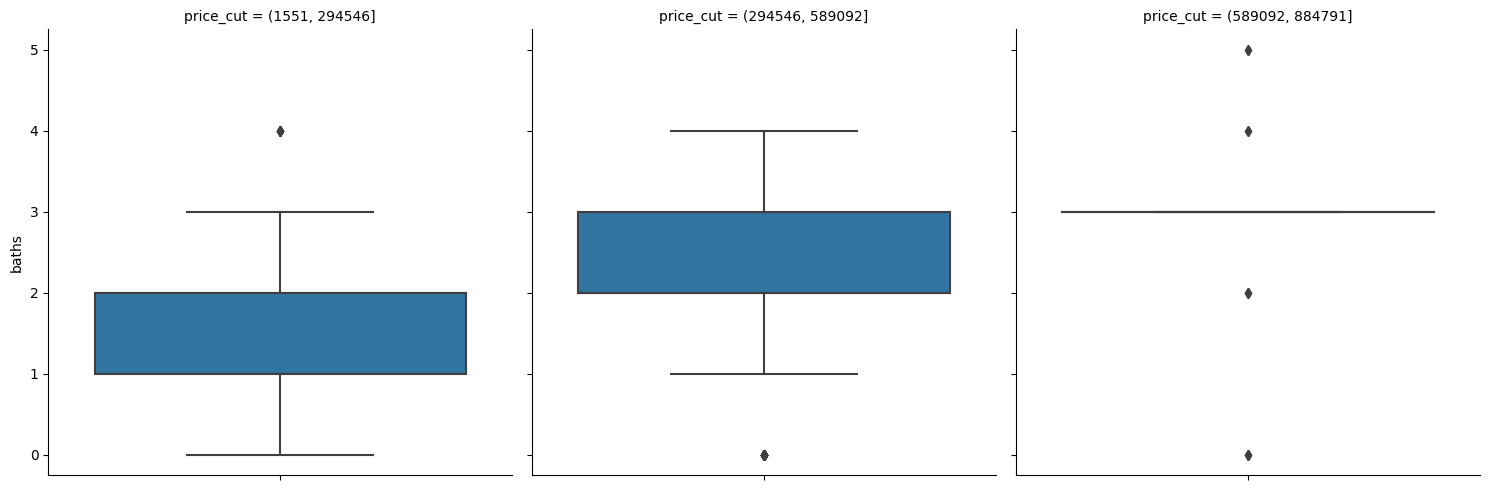

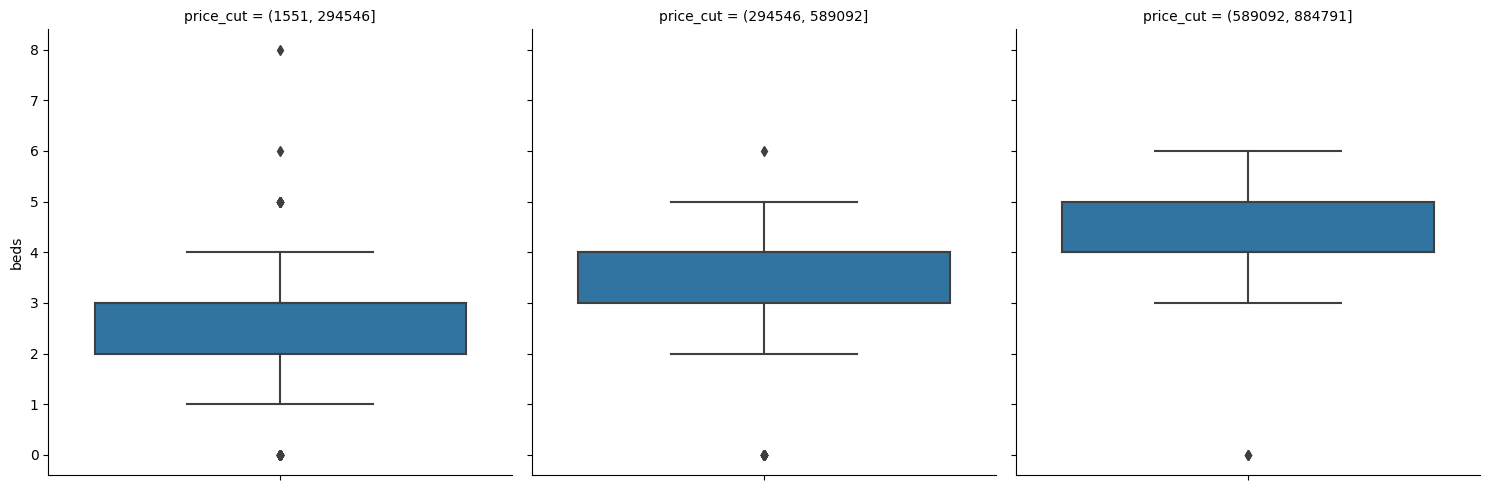

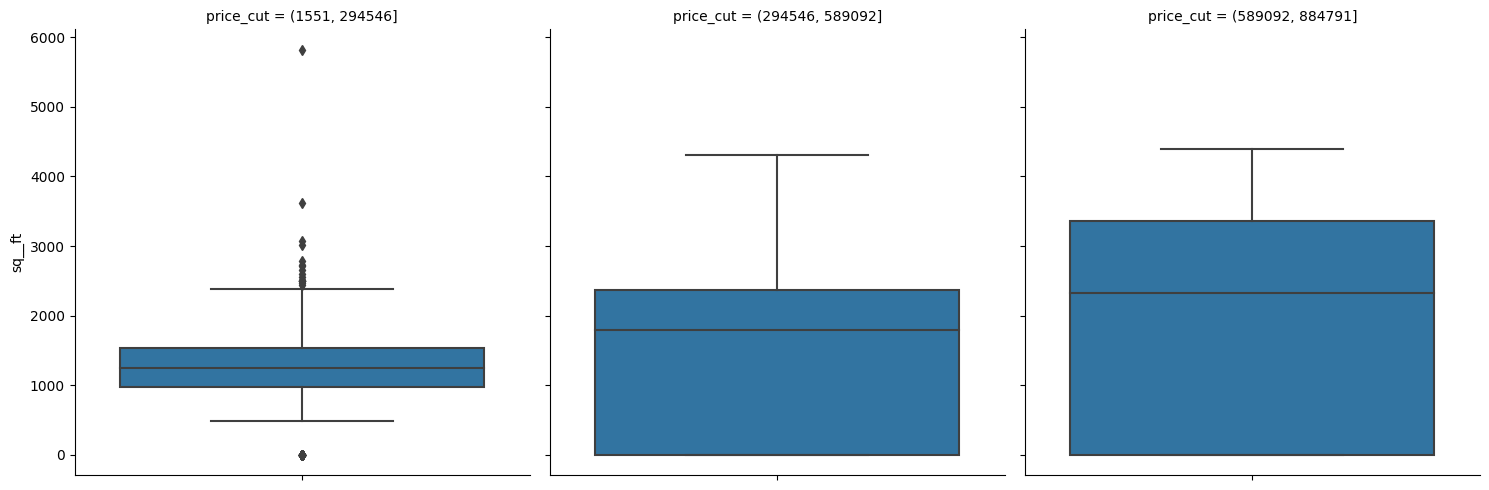

In [29]:
for var in col_list:
    sns.catplot(data=df, y=var, col = 'price_cut', kind='box');

### Usuwanie outlierów

In [30]:
col_list = df[['city','price','zip', 'beds', 'baths','sq__ft', 'latitude','longitude']].columns.tolist()

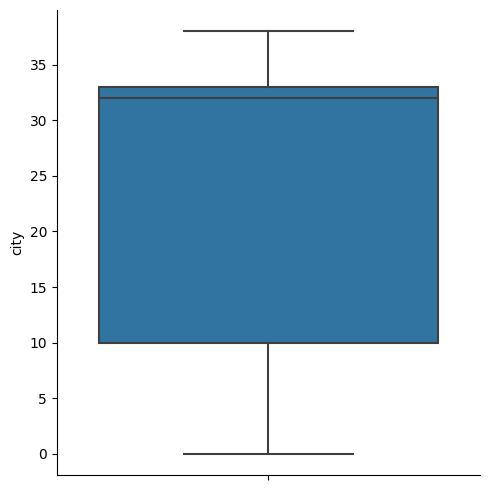

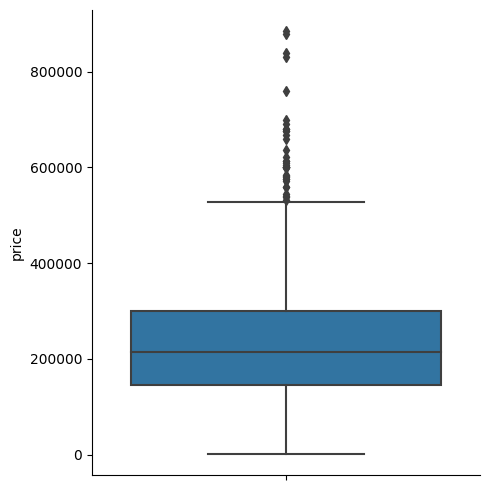

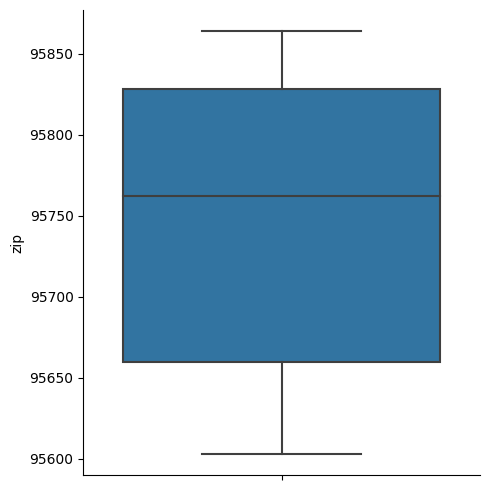

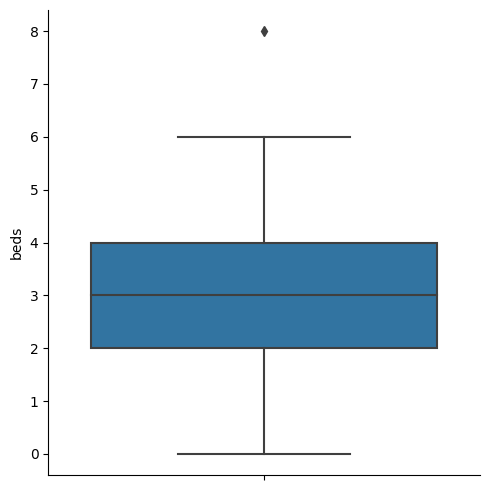

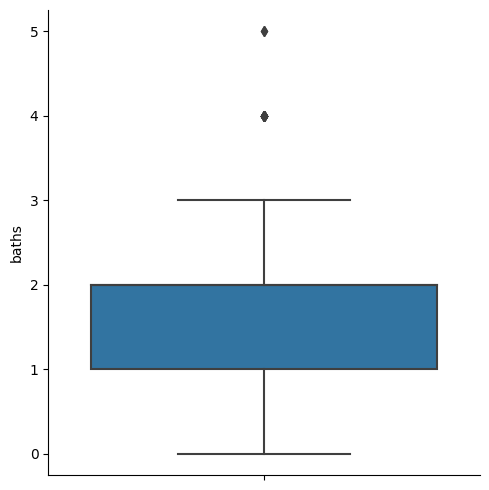

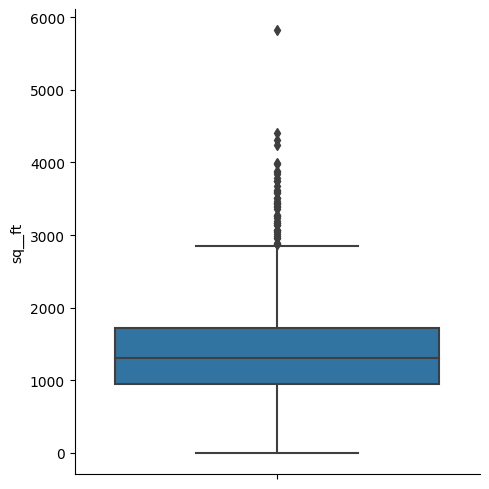

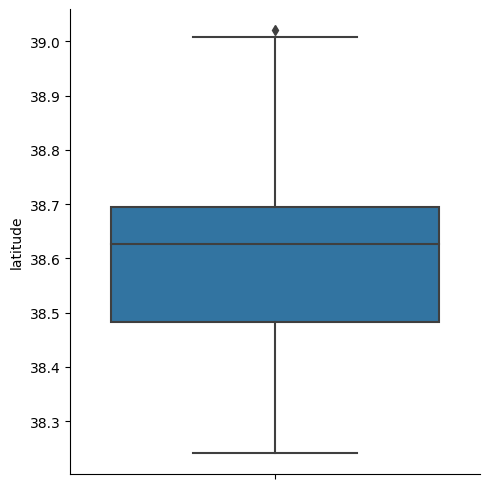

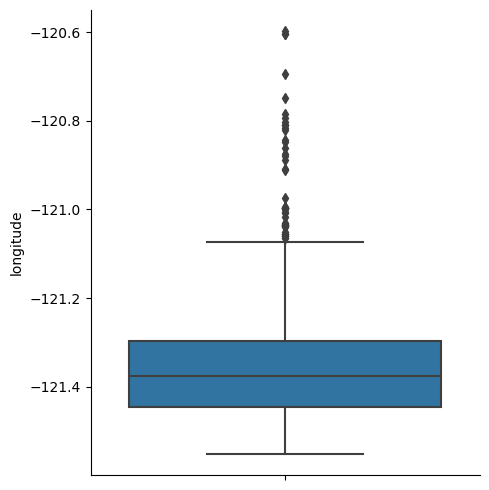

In [31]:
for var in col_list:
    sns.catplot(data=df, y=var, kind='box');

In [32]:
q1 = df.quantile(0.25) # wartości zmiennej na granicy pierwszego i drugiego kwartyla
q3 = df.quantile(0.75) # wartości zmiennej na granicy trzeciego i czwartego kwartyla
iqr = q3 - q1 # rozstęp międzykwartylowy

In [33]:
#tabela podsumowująca stastystyki wartości odstających
low_boundary = (q1 - 1.5 * iqr)
upp_boundary = (q3 + 1.5 * iqr)
num_of_outliers_L = (df[iqr.index] < low_boundary).sum()
num_of_outliers_U = (df[iqr.index] > upp_boundary).sum()
outliers_15iqr = pd.DataFrame({'Dolna_granica_q1':low_boundary, 'Górna_granica_q3':upp_boundary,'Liczba_wart._odstających_poniżej_granicy_q1-iqr':num_of_outliers_L, 'Liczba_wart._odstających_powyżej_granicy_q3+iqr':num_of_outliers_U})

In [34]:
outliers = df.copy()
print('Rozmiar zbioru z obserwacjami odstającymi:', outliers.shape[0])

for row in outliers_15iqr.iterrows():
    outliers = outliers[(outliers[row[0]] >= row[1]['Dolna_granica_q1']) & (outliers[row[0]] <= row[1]['Górna_granica_q3'])]

Rozmiar zbioru z obserwacjami odstającymi: 985


In [35]:
print('Rozmiar zbioru po usunięciu obserwacji odstających:', outliers.shape[0])

Rozmiar zbioru po usunięciu obserwacji odstających: 868


### Skalowanie danych

In [36]:
outliers.drop(['price_cut'], axis = 1, inplace=True)

In [38]:
col_train = list(outliers.columns)

prepro = MinMaxScaler()
prepro=prepro.fit(outliers)

train = pd.DataFrame(prepro.transform(outliers),columns = col_train)
train

,city,zip,beds,baths,sq__ft,sale_date,price,latitude,longitude
0,0.868421,0.900383,0.333333,0.333333,0.296034,1.0,0.111238,0.562482,0.244255
1,0.868421,0.842912,0.500000,0.333333,0.413244,1.0,0.128578,0.342026,0.252307
2,0.868421,0.812261,0.333333,0.333333,0.281870,1.0,0.129866,0.542876,0.225522
3,0.868421,0.812261,0.333333,0.333333,0.301700,1.0,0.130690,0.540758,0.235334
4,0.868421,0.846743,0.333333,0.333333,0.282224,1.0,0.154980,0.400475,0.242396
...,...,...,...,...,...,...,...,...,...
863,0.868421,0.865900,0.666667,1.000000,0.807365,0.5,0.445317,0.311448,0.401605
864,0.868421,0.842912,0.500000,0.666667,0.523017,0.5,0.448355,0.372269,0.194053
865,0.105263,0.026820,0.500000,0.666667,0.430595,0.5,0.450283,0.673294,0.616572
866,0.236842,0.593870,0.666667,0.666667,0.596671,0.5,0.450864,0.252838,0.322565


In [ ]:
# próba z odwórceniem wartości

In [39]:
inversed = pd.DataFrame(prepro.inverse_transform(train),columns = col_train)
inversed

,city,zip,beds,baths,sq__ft,sale_date,price,latitude,longitude
0,33.0,95838.0,2.0,1.0,836.0,4.0,59222.0,38.631913,-121.434879
1,33.0,95823.0,3.0,1.0,1167.0,4.0,68212.0,38.478902,-121.431028
2,33.0,95815.0,2.0,1.0,796.0,4.0,68880.0,38.618305,-121.443839
3,33.0,95815.0,2.0,1.0,852.0,4.0,69307.0,38.616835,-121.439146
4,33.0,95824.0,2.0,1.0,797.0,4.0,81900.0,38.519470,-121.435768
...,...,...,...,...,...,...,...,...,...
863,33.0,95829.0,4.0,3.0,2280.0,2.0,232425.0,38.457679,-121.359620
864,33.0,95823.0,3.0,2.0,1477.0,2.0,234000.0,38.499893,-121.458890
865,4.0,95610.0,3.0,2.0,1216.0,2.0,235000.0,38.708824,-121.256803
866,9.0,95758.0,4.0,2.0,1685.0,2.0,235301.0,38.417000,-121.397424


### Podział zbioru

In [40]:
y=train['price']
X=train.drop(['price'], axis=1)
X_train, X_test, y_train, y_test= train_test_split(X,y,test_size=0.2, random_state=42)

### Regresja liniowa

In [41]:
# kodowanie labelowanie bez usuwania wartości odstających
lr = LinearRegression()
lr.fit(X_train, y_train) # estymacja modelu

pred_train1=lr.predict(X_train) # predykcja na danych treningowych
pred_test1=lr.predict(X_test) # predykcja na danych testowych

# Ocena jakości modelu 
score=r2_score(y_train,pred_train1)
print("r2 Score dla danych treningowych:", score) 
score1=r2_score(y_test,pred_test1)
print("r2 Score dla danych testowych:", score1) 

r2 Score dla danych treningowych: 0.18731935202202898
r2 Score dla danych testowych: 0.16804747966950662


### Ridge

In [42]:
ridge = Ridge()
ridge.fit(X_train, y_train)

pred_train1=ridge.predict(X_train) # predykcja na danych treningowych
pred_test1=ridge.predict(X_test) # predykcja na danych testowych

# Ocena jakości modelu 
score=r2_score(y_train,pred_train1)
print("r2 Score dla danych treningowych:", score) 
score1=r2_score(y_test,pred_test1)
print("r2 Score dla danych testowych:", score1) 

r2 Score dla danych treningowych: 0.18691578686818588
r2 Score dla danych testowych: 0.1714607629096062


#### Optymalizacja hiperparametrów

In [43]:
param = {
    'solver':['svd', 'cholesky', 'lsqr', 'sag'],
    'alpha': [1e-15, 1e-10, 1e-08, 0.001, 0.01, 1, 5, 10,20, 30, 35, 40, 45, 50, 55, 100],
    'fit_intercept':[True, False],
    'normalize':[True, False]
}

In [44]:
model_rid = RandomizedSearchCV(ridge, param_distributions=param, n_iter=30)
model_rid.fit(X_train, y_train)

RandomizedSearchCV(estimator=Ridge(), n_iter=30,
                   param_distributions={'alpha': [1e-15, 1e-10, 1e-08, 0.001,
                                                  0.01, 1, 5, 10, 20, 30, 35,
                                                  40, 45, 50, 55, 100],
                                        'fit_intercept': [True, False],
                                        'normalize': [True, False],
                                        'solver': ['svd', 'cholesky', 'lsqr',
                                                   'sag']})

In [45]:
print(model_rid.best_params_)
print(model_rid.best_score_)

{'solver': 'cholesky', 'normalize': False, 'fit_intercept': True, 'alpha': 1}
0.14441619640829922


In [46]:
pred_test= model_rid.predict(X_test)
score_test=r2_score(y_test,pred_test)
pred_train= model_rid.predict(X_train)
score_train=r2_score(y_train,pred_train)

print("r2 Score dla danych testowych:", score_test) 
print("r2 Score dla danych treningowych:", score_train) 

r2 Score dla danych testowych: 0.1714607629096062
r2 Score dla danych treningowych: 0.18691578686818588


### Drzewo decyzyjne

In [47]:
dtr = DecisionTreeRegressor()
dtr.fit(X_train, y_train)

pred_train1=dtr.predict(X_train) # predykcja na danych treningowych
pred_test1=dtr.predict(X_test) # predykcja na danych testowych

# Ocena jakości modelu 
score=r2_score(y_train,pred_train1)
print("r2 Score dla danych treningowych:", score) 
score1=r2_score(y_test,pred_test1)
print("r2 Score dla danych testowych:", score1) 

r2 Score dla danych treningowych: 0.9999997490516334
r2 Score dla danych testowych: 0.3048781216483023


#### Optymalizacja hiperparametrów

In [48]:
parameters = {
    'max_depth': [None, 2, 3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6] }     

In [49]:
model_dtr = RandomizedSearchCV(dtr, param_distributions=parameters, n_iter=30)
model_dtr.fit(X_train, y_train)

RandomizedSearchCV(estimator=DecisionTreeRegressor(), n_iter=30,
                   param_distributions={'max_depth': [None, 2, 3, 4, 5, 6],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6],
                                        'min_samples_split': [2, 5, 10]})

In [50]:
feature_imp = model_dtr.best_estimator_.feature_importances_

In [51]:
print(model_dtr.best_params_)
print(model_dtr.best_score_)

{'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 4}
0.5321902953683976


In [53]:
pred_test= model_dtr.predict(X_test)
score_test=r2_score(y_test,pred_test)
pred_train= model_dtr.predict(X_train)
score_train=r2_score(y_train,pred_train)

print("r2 Score dla danych testowych:", score_test) 
print("r2 Score dla danych treningowych:", score_train) 

r2 Score dla danych testowych: 0.594506004293075
r2 Score dla danych treningowych: 0.639915388680257


### Las losowy

In [54]:
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)

pred_train1=rfr.predict(X_train) # predykcja na danych treningowych
pred_test1=rfr.predict(X_test) # predykcja na danych testowych

# Ocena jakości modelu 
score=r2_score(y_train,pred_train1)
print("r2 Score dla danych treningowych:", score) 
score1=r2_score(y_test,pred_test1)
print("r2 Score dla danych testowych:", score1) 
rfr_mse = mean_squared_error(y_test,pred_test1)
rfr_rmse = np.sqrt(rfr_mse)
rfr2_mse = mean_squared_error(y_train,pred_train1)
rfr2_rmse = np.sqrt(rfr2_mse)

print(f'RMSE_test: {rfr_rmse}')
print(f'RMSE_train: {rfr2_rmse}')

r2 Score dla danych treningowych: 0.9432763792247125
r2 Score dla danych testowych: 0.6661122093159059
RMSE_test: 0.11401117822384114
RMSE_train: 0.049254764621486855


#### Optymalizacja hiperparametrów

In [55]:
parameters = {
    "max_features": list(range(2,12)),
    "max_depth": [5, 7, 10], 
    "min_samples_leaf": range(1, 21),
    "n_estimators": list(range(1,20)) }   

In [56]:
model_rfr = RandomizedSearchCV(rfr, param_distributions=parameters, n_iter=30)
model_rfr.fit(X_train, y_train)

RandomizedSearchCV(estimator=RandomForestRegressor(), n_iter=30,
                   param_distributions={'max_depth': [5, 7, 10],
                                        'max_features': [2, 3, 4, 5, 6, 7, 8, 9,
                                                         10, 11],
                                        'min_samples_leaf': range(1, 21),
                                        'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8,
                                                         9, 10, 11, 12, 13, 14,
                                                         15, 16, 17, 18, 19]})

In [57]:
feature_imp = model_rfr.best_estimator_.feature_importances_

In [58]:
print(model_rfr.best_params_)
print(model_rfr.best_score_)

{'n_estimators': 18, 'min_samples_leaf': 5, 'max_features': 3, 'max_depth': 10}
0.5709511533775561


In [59]:
data_Fimp = pd.DataFrame({"feature":X_train.columns, "importance": feature_imp}).sort_values("importance", ascending=False)
data_Fimp.head(8)

,feature,importance
4,sq__ft,0.308281
6,latitude,0.201099
7,longitude,0.190672
3,baths,0.114479
1,zip,0.070050
2,beds,0.063445
0,city,0.033139
5,sale_date,0.018835


In [60]:
pred_test= model_rfr.predict(X_test)
score_test=r2_score(y_test,pred_test)
pred_train= model_rfr.predict(X_train)
score_train=r2_score(y_train,pred_train)

print("r2 Score dla danych testowych:", score_test) 
print("r2 Score dla danych treningowych:", score_train) 

r2 Score dla danych testowych: 0.6332445392749684
r2 Score dla danych treningowych: 0.7319593062224443


### XGBoost

In [61]:
xg = XGBRegressor()
xg.fit(X_train, y_train)

pred_train1=xg.predict(X_train) 
pred_test1=xg.predict(X_test) 

# Ocena jakości modelu 
score=r2_score(y_train,pred_train1)
print("r2 Score dla danych treningowych:", score) 
score1=r2_score(y_test,pred_test1)
print("r2 Score dla danych testowych:", score1) 

xg_mse = mean_squared_error(y_test,pred_test1)
xg_rmse = np.sqrt(xg_mse)
xg2_mse = mean_squared_error(y_train,pred_train1)
xg2_rmse = np.sqrt(xg2_mse)

print(f'RMSE_test: {xg_rmse}')
print(f'RMSE_train: {xg2_rmse}')

r2 Score dla danych treningowych: 0.9976284199813815
r2 Score dla danych testowych: 0.6350853449769474
RMSE_test: 0.11919082260859175
RMSE_train: 0.01007129151491992


In [62]:
def display_scores(scores):
    print('Scores:', scores)
    print('Mean:', scores.mean())
    print('Standard Deviation:', scores.std())

In [63]:
# Mamy nadmierne dopasowanie - przetestujemy zbiór na walidacji krzyżowej

In [66]:
kfold = KFold(n_splits=10)
results = cross_val_score(xg, X_train, y_train, cv=kfold)
print("Średnia dokładność każdego podziału: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Średnia dokładność każdego podziału: 54.82% (10.95%)


#### Optymalizacja hiperparametrów

In [67]:
parameters = {
    "max_features": list(range(2,12)),
    "max_depth": [5, 7, 10], 
    "min_samples_leaf": range(1, 21),
    "n_estimators": list(range(1,20)) }                        

In [74]:
model_xg = RandomizedSearchCV(xg, param_distributions=parameters, n_iter=20)
model_xg.fit(X_train, y_train)

[14:45:21] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "max_features", "min_samples_leaf" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:45:22] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "max_features", "min_samples_leaf" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:45:22] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "m

[14:45:22] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "max_features", "min_samples_leaf" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:45:22] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "max_features", "min_samples_leaf" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:45:23] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "m

[14:45:24] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "max_features", "min_samples_leaf" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:45:24] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "max_features", "min_samples_leaf" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:45:24] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "m

[14:45:25] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "max_features", "min_samples_leaf" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:45:25] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "max_features", "min_samples_leaf" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:45:25] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "m

[14:45:26] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "max_features", "min_samples_leaf" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:45:26] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "max_features", "min_samples_leaf" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:45:26] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "m

RandomizedSearchCV(estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          callbacks=None, colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, gamma=0, gpu_id=-1,
                                          grow_policy='depthwise',
                                          importance_type=None,
                                          interaction_constraints='',
                                          learning_rate=0.300000012,
                                          max_bin=256, max_ca...
                                          max_leaves=0, min_child_weight=1,
                                          missing=nan,
                                          monotone_constraints='()',
                                          n_estimators=100, n_jobs=0,
                                          num_parallel_tree=1, predictor='auto',
                                          random_state=0, reg_alpha=0,
                                          reg_lambda=1, ...),
                   n_iter=20,
                   param_distributions={'max_depth': [5, 7, 10],
                                        'max_features': [2, 3, 4, 5, 6, 7, 8, 9,
                                                         10, 11],
                                        'min_samples_leaf': range(1, 21),
                                        'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8,
                                                         9, 10, 11, 12, 13, 14,
                                                         15, 16, 17, 18, 19]})

In [75]:
feature_imp = model_xg.best_estimator_.feature_importances_

In [76]:
print(model_xg.best_params_)
print(model_xg.best_score_)

{'n_estimators': 7, 'min_samples_leaf': 6, 'max_features': 5, 'max_depth': 5}
0.5596729864066381


In [77]:
data_Fimp = pd.DataFrame({"feature":X_train.columns, "importance": feature_imp}).sort_values("importance", ascending=False)
data_Fimp.head(8)

,feature,importance
4,sq__ft,0.391323
6,latitude,0.264144
1,zip,0.090949
7,longitude,0.084891
2,beds,0.056372
3,baths,0.054549
5,sale_date,0.031005
0,city,0.026767


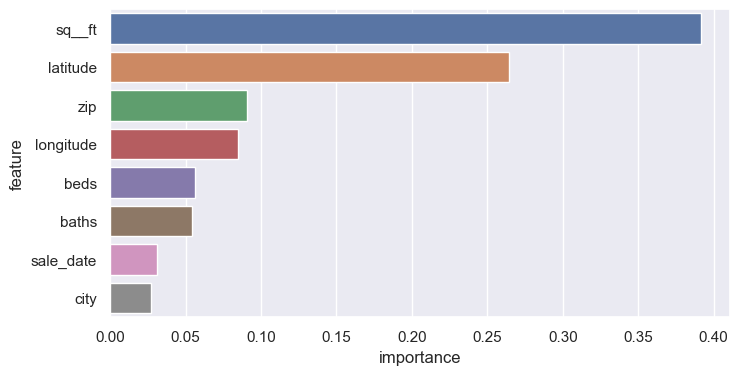

In [78]:
plt.figure(figsize=(8,4))
sns.set(font_scale = 1)
sns.barplot(x="importance", y="feature", data=data_Fimp)
plt.show()

In [79]:
pred_test= model_xg.predict(X_test)
score_test=r2_score(y_test,pred_test)
pred_train= model_xg.predict(X_train)
score_train=r2_score(y_train,pred_train)

print("r2 Score dla danych testowych:", score_test) 
print("r2 Score dla danych treningowych:", score_train) 

r2 Score dla danych testowych: 0.6309364867930823
r2 Score dla danych treningowych: 0.7649293794428658


#### Predykcja

In [80]:
df2=pd.DataFrame({'Actual':y_test,'Predicted':pred_test})
df2

,Actual,Predicted
394,0.447662,0.272179
66,0.371201,0.511507
495,0.006454,0.057840
67,0.372779,0.376030
853,0.427137,0.409888
...,...,...
81,0.450283,0.385935
558,0.247756,0.311216
351,0.319688,0.385935
543,0.199536,0.363549


### Sieci neuronowe

In [81]:
model=Sequential()
model.add(layers.InputLayer(input_shape=(X_train.shape[1])))
model.add(Dense(50, activation='relu')) 
model.add(layers.Dropout(0.1)) 
model.add(Dense(40, activation='relu'))
model.add(layers.Dropout(0.1)) 
model.add(Dense(20, activation='relu'))
model.add(layers.Dropout(0.1)) 
model.add(Dense(10, activation='relu'))
model.add(layers.Dropout(0.1)) 
model.add(Dense(5, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='Adam', loss='mse')

In [82]:
history = model.fit(x=X_train,y=y_train,validation_data=(X_test,y_test),verbose=1,epochs=100)

Epoch 1/100
22/22 [==============================] - 2s 17ms/step - loss: 0.2109 - val_loss: 0.1613
Epoch 2/100
22/22 [==============================] - 0s 5ms/step - loss: 0.1720 - val_loss: 0.1351
Epoch 3/100
22/22 [==============================] - 0s 5ms/step - loss: 0.1395 - val_loss: 0.0961
Epoch 4/100
22/22 [==============================] - 0s 5ms/step - loss: 0.0867 - val_loss: 0.0373
Epoch 5/100
22/22 [==============================] - 0s 5ms/step - loss: 0.0545 - val_loss: 0.0344
Epoch 6/100
22/22 [==============================] - 0s 5ms/step - loss: 0.0476 - val_loss: 0.0331
Epoch 7/100
22/22 [==============================] - 0s 5ms/step - loss: 0.0430 - val_loss: 0.0319
Epoch 8/100
22/22 [==============================] - 0s 5ms/step - loss: 0.0446 - val_loss: 0.0309
Epoch 9/100
22/22 [==============================] - 0s 5ms/step - loss: 0.0412 - val_loss: 0.0300
Epoch 10/100
22/22 [==============================] - 0s 5ms/step - loss: 0.0381 - val_loss: 0.0294
Epoch 11

Epoch 83/100
22/22 [==============================] - 0s 5ms/step - loss: 0.0172 - val_loss: 0.0172
Epoch 84/100
22/22 [==============================] - 0s 5ms/step - loss: 0.0181 - val_loss: 0.0168
Epoch 85/100
22/22 [==============================] - 0s 5ms/step - loss: 0.0177 - val_loss: 0.0164
Epoch 86/100
22/22 [==============================] - 0s 5ms/step - loss: 0.0171 - val_loss: 0.0156
Epoch 87/100
22/22 [==============================] - 0s 5ms/step - loss: 0.0183 - val_loss: 0.0158
Epoch 88/100
22/22 [==============================] - 0s 4ms/step - loss: 0.0177 - val_loss: 0.0175
Epoch 89/100
22/22 [==============================] - 0s 5ms/step - loss: 0.0162 - val_loss: 0.0171
Epoch 90/100
22/22 [==============================] - 0s 4ms/step - loss: 0.0188 - val_loss: 0.0178
Epoch 91/100
22/22 [==============================] - 0s 5ms/step - loss: 0.0171 - val_loss: 0.0180
Epoch 92/100
22/22 [==============================] - 0s 5ms/step - loss: 0.0190 - val_loss: 0.0168


In [83]:
pred=model.predict(X_test)
print('mse: ', (mean_squared_error(y_test, pred))**.5, 'r2 score_test: ', r2_score(y_test, pred))

6/6 [==============================] - 0s 2ms/step
mse:  0.12743802133861556 r2 score_test:  0.5828389898871238


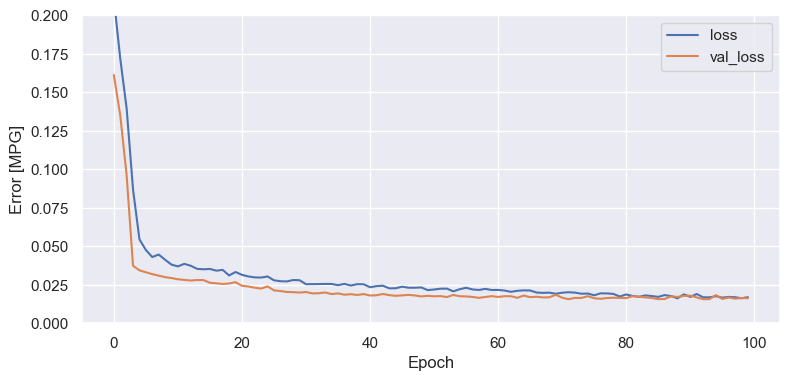

In [84]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 0.2])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)

fig=plt.figure(figsize=(9,4))
plot_loss(history)

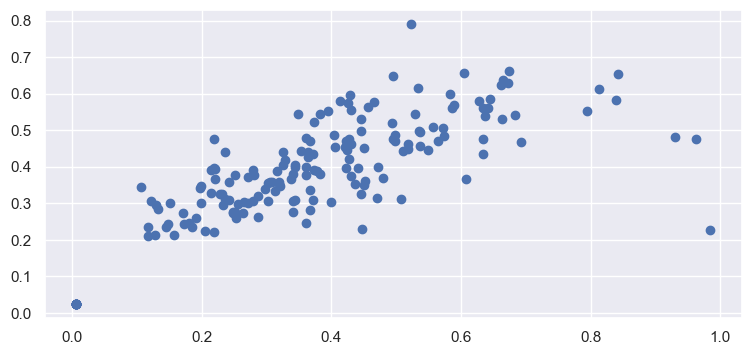

In [85]:
fig=plt.figure(figsize=(9,4))
plt.scatter(y_test, pred);

### Porównanie modeli

In [92]:
def regression_(x,y):
       
    algos=[lr,model_rid,model_dtr,model_rfr,model_xg]
    algos_names=['LinearRegressor','Ridge','DecisionTree','RandomForest','XGB']
    
    r_score_test=[]
    r_score_train=[]
    mse=[]
    mae=[]
    
    result=pd.DataFrame(columns=['R_square_test','R_square_train','MSE','MAE'],index=algos_names) 
    
    for algo in algos:
        pred=algo.fit(X_train,y_train).predict(X_test)
        r_score_test.append(r2_score(y_test,pred))
        pred2=algo.fit(X_train,y_train).predict(X_train)
        r_score_train.append(r2_score(y_train,pred2))
        mse.append(mean_squared_error(y,pred)**.5)
        mae.append(mean_absolute_error(y,pred))
     
    result.R_square_test=r_score_test
    result.R_square_train=r_score_train
    result.MSE=mse
    result.MAE=mae
    
    return result.sort_values('R_square_test',ascending=False)

In [93]:
regression_(X_test,y_test)

[14:49:16] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "max_features", "min_samples_leaf" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:49:16] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "max_features", "min_samples_leaf" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:49:17] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "m

[14:49:17] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "max_features", "min_samples_leaf" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:49:18] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "max_features", "min_samples_leaf" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:49:18] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "m

[14:49:18] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "max_features", "min_samples_leaf" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:49:18] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "max_features", "min_samples_leaf" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:49:18] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "m

[14:49:19] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "max_features", "min_samples_leaf" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:49:19] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "max_features", "min_samples_leaf" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:49:19] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "m

[14:49:21] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "max_features", "min_samples_leaf" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:49:21] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "max_features", "min_samples_leaf" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:49:21] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "m

[14:49:21] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "max_features", "min_samples_leaf" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:49:22] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "max_features", "min_samples_leaf" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:49:22] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "m

[14:49:22] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "max_features", "min_samples_leaf" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:49:22] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "max_features", "min_samples_leaf" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:49:23] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "m

[14:49:23] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "max_features", "min_samples_leaf" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:49:23] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "max_features", "min_samples_leaf" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:49:23] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "m

[14:49:24] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "max_features", "min_samples_leaf" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:49:24] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "max_features", "min_samples_leaf" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:49:24] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "m

[14:49:25] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "max_features", "min_samples_leaf" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:49:25] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "max_features", "min_samples_leaf" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:49:25] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "m

,R_square_test,R_square_train,MSE,MAE
RandomForest,0.670183,0.720139,0.113314,0.085380
XGB,0.640731,0.764929,0.118265,0.089678
DecisionTree,0.594506,0.639915,0.125643,0.096038
Ridge,0.176458,0.187259,0.179056,0.143019
LinearRegressor,0.168047,0.187319,0.179968,0.143168
